In [8]:
# import the usual
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from ipywidgets import interact, fixed
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

Here, we put the csv files into dataframe and we try to fit them into X and Y

In [9]:
df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

correlation_matrix = df_result_numerical.corr()

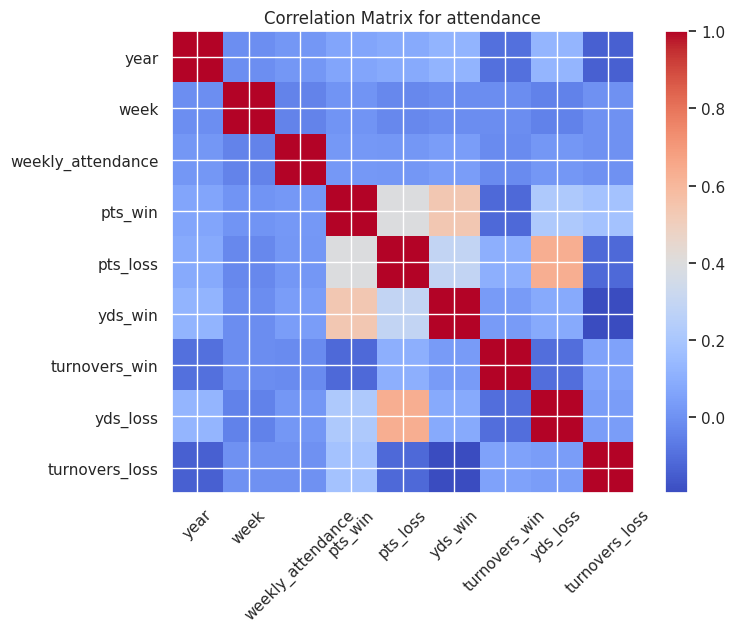

In [10]:
plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix for attendance")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()


In [11]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train[[col]])
    encoded_test = encoder.transform(X_test[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)

/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse

In [13]:
model = SVR()

In [14]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.2, 0.5]
}

In [15]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [16]:
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_result = grid_search.fit(X_train_encoded, y_train)

In [17]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10.0, 'epsilon': 0.5, 'kernel': 'linear'}


In [19]:
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_encoded)
mse = mean_squared_error(y_test, y_pred)
print("Final Mean Squared Error on Test Set:", mse)

[66737.31442354 70501.49213705 66842.93152544 67212.89430824
 66250.59434471 69011.18080512 68126.08108953 68349.41809068
 68630.09253273 67116.63610205 69636.8545132  69345.2789459
 68249.68233875 68238.89519313 67214.02569256 67963.15275178
 67766.34031126 69336.67584345 66214.72426239 67513.14606235
 67371.1779469  67878.27695647 69412.66553852 68867.57302836
 69289.20174608 70083.47095988 66851.82668171 69744.41526506
 68975.77963117 69101.96017501 67726.08278427 68544.63812492
 68228.6544523  70688.96349839 69222.12383661 69927.42830745
 67502.91407285 67414.71280739 68474.64606533 69526.11532537
 70789.16941181 69269.15096555 69123.4285045  66687.7194728
 66630.39676932 69660.92223576 66393.70484779 69647.02790979
 65641.86284253 66693.83493427 66708.01743249 66891.71950928
 69026.34570334 68135.0507426  70262.07894513 68491.35404841
 66079.84899727 67204.63135884 67911.61217466 68630.12002311
 67682.55972758 69062.9352527  67046.90064368 69105.67211816
 67472.93605444 69271.3506